## Coursework 3: document models
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/cw/coursework3.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1819/). This version adapted by Damon Wischik._

This coursework involves aggregating, summarizing, and joining datasets. This may be done with straight Python, or with MATLAB-style manipulations using `numpy`, or with `pandas` dataframes. If you anticipate future work in machine learning and data science then you should learn to use `pandas` dataframes, and you may find it helpful to follow the walkthrough in [Section 3](https://notebooks.azure.com/djw1005/libraries/cl-scicomp/html/3.%20Working%20with%20data.ipynb) of IA _Scientific Computing_. If you prefer not to use dataframes, and you have questions about how they are being used in the code snippets below, ask your classmates or Dr Wischik.

**What to submit.**
Your answers should contain an explanation of what you do, and
2&ndash;4 central commands to achieve it. Complete listings are
unnecessary. The focus of your answer should be
_interpretation:_ explain what the numerical values and graphs
you produce _mean,_ and why they are as they are.  The text of
your answer to each question should be no more than a paragraph or
two.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import pandas
import requests, io
import time
from math import floor

## Data import

The data is provided as `http://mlg.eng.cam.ac.uk/teaching/4f13/1112/cw/kos_doc_data.mat`. It contains two matrices $A$ and $B$ for training and testing respectively, both matrices with 3 columns: document ID, word ID, and word count. The words themselves are the vector $V$, where e.g. `V[840]='bush'`. The following snippet reads in the data, and converts $A$ and $B$ to dataframes.

In [2]:
r = requests.get('http://mlg.eng.cam.ac.uk/teaching/4f13/1112/cw/kos_doc_data.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    V = np.array([i[0] for i in data['V'].squeeze()])
    A,B = [pandas.DataFrame({'doc_id': M[:,0]-1, 'word_id': M[:,1]-1, 'count': M[:,2]}, 
                            columns=['doc_id','word_id','count']) 
           for M in (data['A'],data['B'])] 


## Question (a): simple categorical model

Suppose we model words in a document as independent samples from a categorical distribution with parameter $\beta$, where $\beta_v$ is the probability of word $v\in V$. Using $A$ as the training set, find the maximum likelihood estimator $\hat{\beta}$, and plot the 20 most-probable words in a histogram. What is the log probability of the test document `doc_id=2527`, given $\hat{\beta}$? Briefly interpret your answer.

Note: you can plot a histogram with
```
with plt.rc_context({'figure.figsize': (5,8)}):            # set plot size
    plt.barh(np.arange(20), top_20_probs, align='center')  # draw bars
plt.yticks(np.arange(20), top_20_words)                    # label the y axis
plt.xlabel(r'$\hat{\beta}$')                               # label the x axis
plt.gca().invert_yaxis()                                   # optionally, flip the y-axis
plt.show()
```

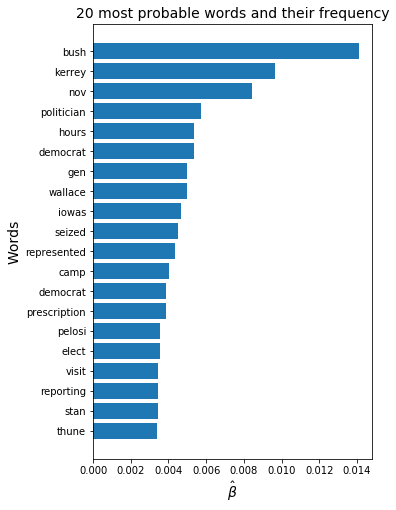

In [3]:
# Construct a frequency vector over words, divide by number of words in the documents
N = V.shape[0]
counts = np.zeros(N)
for i, element in enumerate(A['word_id']):
    counts[element] += A['count'][i]

beta_hat = np.divide(counts, A['count'].sum())

# Find the 20 most probable words:
temp = list(beta_hat)
most_prob_id = np.zeros(20).astype(int)
most_prob_value = np.zeros(20)
for i in range(20):
    most_prob_value[i] = max(temp)
    most_prob_id[i] = int(temp.index(max(temp)))
    temp.remove(max(temp))
# Plot the 20 most probable words 
top_20_probs = most_prob_value 
top_20_words = V[most_prob_id]
with plt.rc_context({'figure.figsize': (5,8)}):            # set plot size
    plt.barh(np.arange(20), top_20_probs, align='center')  # draw bars
plt.yticks(np.arange(20), top_20_words)                    # label the y axis
plt.xlabel(r'$\hat{\beta}$', fontsize = 14)   
plt.ylabel('Words', fontsize = 14)
plt.gca().invert_yaxis()
plt.title('20 most probable words and their frequency', fontsize = 14)
plt.show()


In [4]:
# Find the log likelihood of document "doc_id=2527"
# First find frequency of words
words_in_2527 = np.zeros(N)
for i, element in enumerate(B['doc_id']):
    if element == 2527:
        words_in_2527[B['word_id'][i]] += B['count'][i]

# Now determine log likelihood
b_power_c = np.power(beta_hat, words_in_2527)
b_power_c = b_power_c[b_power_c != 1]
print(b_power_c)


[3.71462828e-04 9.56240943e-05 3.31006480e-05 1.27486655e-06
 6.62012961e-05 1.09565290e-07 3.60429279e-04 1.61825390e-04
 1.02979794e-04 4.41341974e-05 7.35569956e-06 2.24348837e-04
 1.37984633e-07 7.15556030e-09 1.40971982e-02 3.63810869e-07
 4.42950950e-27 2.11352797e-07 1.21369043e-04 2.35382386e-04
 7.46603506e-04 9.19462445e-05 7.09347330e-07 9.55106170e-15
 8.41780677e-26 1.13758530e-08 5.95811665e-04 1.61825390e-04
 3.65758697e-08 1.69181090e-04 1.65503240e-04 2.50093785e-04
 2.85574354e-05 1.76536790e-04 6.65690811e-04 2.28762256e-03
 1.28724742e-04 8.82683948e-05 1.17691193e-04 1.06657644e-04
 1.21369043e-04 9.14396742e-09 1.25046893e-04 4.78120472e-05
 3.38164475e-08 1.94926038e-04 4.70764772e-04 9.93019441e-05
 1.94926038e-04 1.54469691e-04 5.14898969e-05 4.22952725e-04
 3.38362180e-04 3.27328631e-04 1.14013343e-04 1.21369043e-04
 4.04563476e-05 5.88455965e-05 7.72348454e-05 6.65690811e-04
 1.05554289e-03 4.23779545e-12 3.56751429e-04 6.98791459e-04
 9.77295334e-08 1.435034

### Comment:
Since we use a niave model than only leverages the counts of words in the training set, when facing unseen words, the probability of them occuring will be zero and hence will the pobability of the document occuring be zero. Log prob will then be -inf.

## Question (b): Bayesian inference

For the categorical model in part (a), use Bayesian inference to find the posterior distribution of $\beta$ given the training set $A$, using a symmetric Dirichlet distribution with concentration parameter $\alpha=0.1$ as prior. Let $\tilde{\beta}_v$ be the posterior predictive probability of word $v\in V$, i.e. the posterior probability that a newly chosen word is $v$. Derive an expression for $\tilde{\beta}_v$, and compare it to $\hat{\beta}_v$. Explain the implications, both for common and for rare words.

Hint: $\Gamma(z+1)=z\,\Gamma(z)$.

In [5]:
# Pseudo counts
alpha = 0.1*np.ones(N)
beta_tilde = counts + alpha
beta_tilde = np.divide(beta_tilde, A['count'].sum()+alpha.sum())
# Find the log likelihood of document "doc_id=2527"
# First find frequency of words
words_in_2527 = np.zeros(N)
for i, element in enumerate(B['doc_id']):
    if element == 2000:
        words_in_2527[B['word_id'][i]] = B['count'][i]

# Now determine log likelihood
b_power_c = np.power(beta_tilde, words_in_2527)
b_power_c = b_power_c[b_power_c != 1]
log_prob = np.sum(np.log(b_power_c))
print(beta_tilde[most_prob_id])

[1.40618500e-02 2.97151091e-05 1.00921315e-03 7.00689611e-05
 4.36922160e-04 9.76196363e-04 2.09473177e-04 1.50409812e-05
 2.23780452e-05 4.07207051e-05 6.27318971e-05 1.21428409e-04
 9.76196363e-04 7.37374931e-05 1.58113729e-04 8.10745570e-05
 2.09473177e-04 2.71838221e-04 8.47430890e-05 1.43439601e-04]


## Question (c): interpretation

In information theory, the _self-information_ of a document $w$ is defined as $i(w) = -\log_2 p(w)$, where $p(\cdot)$ is the probability mass function for the document generating model that you have fitted. The self-information can be interpreted as the number of bits needed to encode or transmit $w$. The number of bits needed per word is thus $i(w)/n$. In text modelling, it is more common to use the terms _perplexity_ for $2^{i(w)}$, and _per-word perplexity_ for $2^{i(w)/n}$. Loosely speaking, if the per-word perplexity is $g$ then the uncertainty in the next word is the same as the uncertainty in a $g$-sided die.

For the trained Bayesian model from part (b), what is the per-word perplexity of the test document `doc_id=2000`? Plot a histogram showing the distribution of per-word perplexity over all the test documents (using [`plt.hist`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html?highlight=matplotlib%20pyplot%20hist#matplotlib.pyplot.hist)). Pick out two documents, one with high per-word perplexity and one with low per-word perplexity, show their contents, and interpret the difference between them.

In [6]:
# Finding per word perplexity for document 2000
doc_id = 2000
words_in_2000 = np.zeros(N)
for i, element in enumerate(B['doc_id']):
    if element == 2000:
        words_in_2000[B['word_id'][i]] = B['count'][i]
    
log_doc_prob = 0
for i , element in enumerate(words_in_2000):
    log_doc_prob = log_doc_prob + element*np.log2(beta_tilde[i])
n_words_in_2000 = sum(words_in_2000)
print(log_doc_prob)
print(2**(-log_doc_prob/n_words_in_2000))

-5325.30015663397
4398.984801609572


In [6]:
# Finding per word perplexity for all documents
# First find frequency of words in all documents
doc_n = B['doc_id'].iloc[B['doc_id'].shape[0]-1]+1
per_doc_count = np.zeros((N, doc_n))
per_doc_perplex = np.zeros(doc_n)
for i, document in enumerate(B['doc_id']):
    per_doc_count[B['word_id'][i], document] = B['count'][i]

p = np.array([])
for i in np.arange(2000, B['doc_id'].iloc[B['doc_id'].shape[0]-1], 1):
    words_in_doc = per_doc_count[:,i]
    n_words_in_doc = sum(words_in_doc)
    log_doc_prob = np.sum(np.multiply(words_in_doc,np.log2(beta_tilde)))
    per_doc_perplex[i] = 2**(-log_doc_prob/n_words_in_doc)
    if n_words_in_doc > 200 and n_words_in_doc < 300:
        p = np.append(p,[per_doc_perplex[i]])
        
print(np.mean(p))
per_doc_perplex = per_doc_perplex[2000:3429]


2831.4952329277485


-183.85999999999999


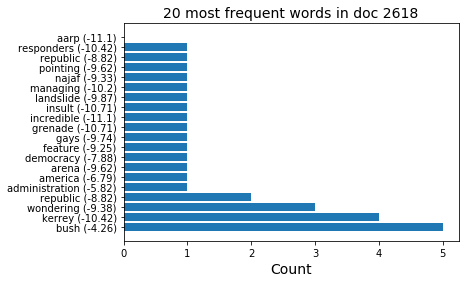

In [8]:
# Construct a frequency vector over words, divide by number of words in the documents
N = V.shape[0]
counts = np.zeros(N)
for i, element in enumerate(B['word_id']):
    if B['doc_id'][i] == 2618:
        counts[element] += B['count'][i]

# Find the 20 most probable words:
temp = list(counts)
most_prob_id = np.zeros(20).astype(int)
most_prob_value = np.zeros(20)
for i in range(20):
    most_prob_value[i] = max(temp)
    most_prob_id[i] = int(temp.index(max(temp)))
    temp.remove(max(temp))
# Plot the 20 most probable words 
top_20_probs = most_prob_value 
top_20_words = list(V[most_prob_id])
top_20_log = 0
for i, element in enumerate(most_prob_id):
    top_20_words[i] = top_20_words[i] +' (' + str(round(np.log(beta_tilde[element]),2)) + ')'
    top_20_log += round(np.log(beta_tilde[element]),2)
print(top_20_log)

plt.barh(np.arange(20), top_20_probs, align='center', linewidth = 3)  # draw bars
plt.yticks(np.arange(20), top_20_words, fontsize = 10)                    # label the y axis
plt.xlabel('Count', fontsize = 14)   
plt.title('20 most frequent words in doc 2618', fontsize = 14)
plt.show()



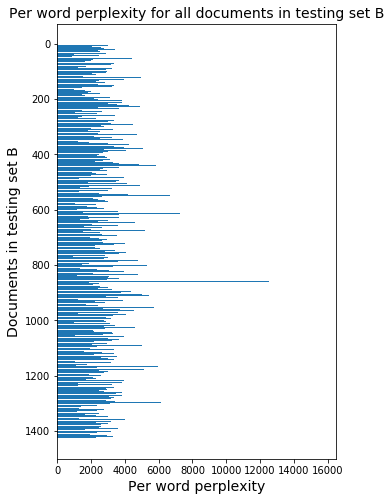

In [9]:
with plt.rc_context({'figure.figsize': (5,8)}):           
    plt.barh(np.arange(per_doc_perplex.shape[0]), per_doc_perplex, align='center', linewidth = 5) 
plt.xlabel('Per word perplexity', fontsize = 14) 
plt.ylabel('Documents in testing set B', fontsize = 14)
plt.gca().invert_yaxis()  
plt.title("Per word perplexity for all documents in testing set B", fontsize = 14)
plt.show()

In [87]:
temp = list(per_doc_perplex)
print(min(temp))
print(int(temp.index(min(temp))))
print(max(temp))
print(int(temp.index(max(temp))))

399.25263555296976
618
15741.827170457318
401


## Question (d): Gibbs sampler for the mixture-of-multinomials model

The Bayesian mixture-of-multinomials model can be described by the following code:

In [7]:
def bmm_generate(doc_length, V, α, γ, K):
    # doc_length = [num words in doc1, num words in doc2, ...]
    θ = np.random.dirichlet(α * np.ones(K))              # prob dist over document classes {1,...,K}
    β = np.random.dirichlet(γ * np.ones(len(V)), size=K) # for each doc class, a prob dist over words
    z = np.random.choice(K, p=θ, size=len(doc_length))   # doc class of each document
    return [np.random.choice(V, p=β[zd], size=nd) for zd,nd in zip(z, doc_length)]

for doc in bmm_generate(doc_length=[5,2,4], V=V, α=10, γ=.1, K=20):
    print(doc)

['petitions' 'falling' 'sufficient' 'inclined' 'tipp']
['nice' 'yanks']
['gang' 'murkowski' 'republican' 'leaked']


The following code implements a collapsed Gibbs sampler. Complete the line that defines `logp`. In each sweep, the Gibbs sampler produces a sample of document classes, and this sample induces a posterior predictive distribution for the probability of each class. Plot how this distribution evolves as a function of the number of Gibbs sweeps. How many iterations does it take to converge?

The Gibbs sampler may be run as follows:

In [9]:
np.random.seed(2)
def bmm_gibbs(doc_label, word_id, count, W, α, γ, K):
    # doc_labels = distinct values of doc_label
    # doc_index = a list as long as doc_label
    #             such that doc_labels[doc_index[j]] = doc_label[j]
    doc_labels, doc_index = np.unique(doc_label, return_inverse=True)

    # z[i] = class of document i, where i enumerates the distinct doc_labels
    # doc_count[k] = number of documents of class k
    z = np.random.choice(K, len(doc_labels))
    doc_count = np.zeros(K, dtype=int)
    for k in z: doc_count[k] += 1

    # occurrences[k,w] = number of occurrences of word_id w in documents of class k
    # word_count[k] = total number of words in documents of class k
    x = pandas.DataFrame({'doc_class': z[doc_index], 'word_id': word_id, 'count': count}) \
        .groupby(['doc_class', 'word_id']) \
        ['count'].apply(sum) \
        .unstack(fill_value=0)
    occurrences = np.zeros((K, W))
    occurrences[x.index.values.reshape((-1,1)), x.columns.values] = x
    word_count = np.sum(occurrences, axis=1)

    while True:
        for i in range(len(doc_labels)):

            # get the words,counts for document i
            # and remove this document from the counts
            w,c = word_id[doc_index==i].values, count[doc_index==i].values
            occurrences[z[i], w] -= c
            word_count[z[i]] -= sum(c)
            doc_count[z[i]] -= 1
            # Find the log probability that this document belongs to class k, marginalized over θ and β
            logp = np.zeros(K)
            for k in range(K):
                temp = np.dot(np.log(occurrences[k, w] + γ) - np.log(word_count[k] + γ * W), np.transpose(c))
                logp[k] = np.log(doc_count[k] + α) + temp    
            p = np.exp(logp - np.max(logp))
            p = p/sum(p)

            # Assign this document to a new class, chosen randomly, and add back the counts
            k = np.random.choice(K, p=p)
            z[i] = k
            occurrences[k, w] += c
            word_count[k] += sum(c)
            doc_count[k] += 1
        
        yield np.copy(z)

In [10]:
g = bmm_gibbs(A['doc_id'], A['word_id'], A['count'], W=len(V), α=10, γ=.1, K=20)
NUM_ITERATIONS = 30
res = np.stack([next(g) for _ in range(NUM_ITERATIONS)])
# this produces a matrix with one row per iteration and a column for each unique doc_id


In [24]:
K = 20
n_doc = 2000
count_of_classes = np.zeros((NUM_ITERATIONS, K))
for i in range(NUM_ITERATIONS):
    for j in range(n_doc):
        count_of_classes[i, res[i,j]] += 1

prob_of_classes = count_of_classes/n_doc

doc_n = A['doc_id'].iloc[A['doc_id'].shape[0]-1]+1
per_doc_count = np.zeros((N, doc_n))
for i, document in enumerate(A['doc_id']):
    per_doc_count[A['word_id'][i], document] = A['count'][i]
    
probs = prob_of_classes[25,:]
probs_class = np.flip(np.argsort(probs))[0:8]
probs = probs[probs_class]
probs = -np.log2(probs)
print(probs)
print(probs_class)

[1.38270152 2.87832144 3.09541957 3.93236128 3.98850436 4.29335894
 4.44222233 4.87832144]
[18 16 13 17  8  7 15  0]
4.0


In [47]:
docs_in_class_k = {}
for i in range(20):
    docs_in_class_k[str(i)] = []
for i, k in enumerate(res[25,:]):
    if k in probs_class:
        docs_in_class_k[str(k)].append(i)
        

In [87]:
prob_words_per_class = np.zeros((20,N))
for c in probs_class:
    for element in docs_in_class_k[str(c)]:
        prob_words_per_class[c,:] += per_doc_count[:,element]

class_probs = np.zeros((20,N))
for i in range(20):
    if i in probs_class:
        class_probs[i,:] = prob_words_per_class[i,:]/sum(prob_words_per_class[i,:])
    

In [88]:
prob_8_class = prob_words_per_class[probs_class,:]
class_8_prob = class_probs[probs_class,:]

In [89]:
temp = prob_8_class
t = class_8_prob
most_prob_id = np.zeros((8,8)).astype(int)
most_prob_value = np.zeros((8,8))
most_prob_prob = np.zeros((8,8))
# Iterate over 8 classes
for i in range(8):
    # Iterate over 8 words
    temp2 = list(temp[i,:])
    t2 = list(t[i,:])
    for j in range(8):
        most_prob_value[i,j] = max(temp2)
        most_prob_prob[i,j] = max(t2)
        most_prob_id[i,j] = int(temp2.index(max(temp2)))
        temp2.remove(max(temp2))
        t2.remove(max(t2))

In [91]:
print(most_prob_value)
print(V[most_prob_id])
print(-np.log2(most_prob_prob))

[[1718. 1024.  854.  623.  614.  533.  515.  425.]
 [ 374.  340.  336.  272.  243.  235.  231.  217.]
 [ 911.  770.  373.  268.  267.  262.  219.  155.]
 [ 296.  254.  224.  209.  156.  147.  131.  110.]
 [ 377.  361.  274.  240.  221.  203.  165.  135.]
 [1044.  294.  276.  267.  251.  239.  239.  235.]
 [ 966.  261.  236.  211.  204.  202.  196.  192.]
 [ 100.   93.   76.   59.   57.   55.   55.   50.]]
[['bush' 'irans' 'wanting' 'administration' 'preserve' 'penny' 'kernan'
  'ties']
 ['senate' 'house' 'quoting' 'repub' 'elections' 'started' 'democratic'
  'campaign']
 ['bush' 'kerrey' 'politicians' 'peoples' 'gene' 'volunteered'
  'politicians' 'startspan']
 ['dean' 'kerrey' 'democrat' 'campaign' 'bush' 'price' 'edt' 'involve']
 ['kerry' 'dean' 'edward' 'clark' 'prices' 'politically' 'democracy'
  'genuinely']
 ['november' 'bush' 'kerrey' 'voter' 'hours' 'politically' 'reproductive'
  'selected']
 ['november' 'politics' 'house' 'sell' 'repub' 'poll' 'bush'
  'governments']
 ['senate

In [185]:
plt.figure()
for i in range(K):
    plt.plot(np.arange(0, NUM_ITERATIONS, 1), prob_of_classes[:,i])
plt.title('Probability of each class as a function of Gibbs iteration', fontsize = 14)
plt.xlabel('Iteration of Gibbs sampling', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.show()

## Question (e): interpretation

Let $\alpha=10$, $\gamma=0.1$, $K=20$. Run the Gibbs sampler until it converges, and find the posterior predictive probabilities for topics, and for words within each topic. 
For each the 8 most popular topics, print the probability of the topic and the 8 most probable words and their probabilities.
Display probabilities in _shannons_, i.e. display a probability $p$ as $-\log_2 p$. An increase of 1 shannon corresponds to a 50% decrease in probability.

Rerun with different random seeds. Do you think this method has succeeded in identifying topics?

**Optional.** There are some words that are very common across all topics. How might we pick out the _distinctive_ words for each topic?

## Question (f): evaluation

**Optional.** Give a formula for per-word perplexity for the mixture model, in terms of the posterior predictive probabilities for topics and words.

**Optional.** Plot a histogram showing the distribution of per-word perplexity over all the test documents for the model in part (e). Also plot the histogram obtained from $K=8$, and the histogram from the plain multinomial model in part (c). Which model do you prefer, and why?